In [1]:
import os
import time
import math
import random
import logging
import warnings
import operator
import numpy as np
from copy import copy
from typing import Tuple
from functools import reduce

import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torch.optim.adam import Adam
from torchvision import transforms
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid, save_image

import matplotlib
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from monty.collections import AttrDict
import matplotlib.patheffects as PathEffects

from CNNUtils import train, test, valid, output_metric

%matplotlib inline

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed_everything()

In [3]:
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.,), (1,))])

mnist_train = torchvision.datasets.MNIST('./data/', train=True, transform=trans, download=True)
mnist_train, mnist_val = random_split(mnist_train, [10000, 50000], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=mnist_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True)

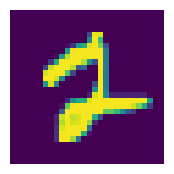

In [4]:
dataiter = iter(train_loader)
sample = next(dataiter)[0][0]
sample = sample.numpy().transpose(1, 2, 0)
plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

In [5]:
def Conv2dStack(in_channels=1, out_channels=[128, 128, 128, 128], kernel_sizes=[3, 3, 3, 3], strides=[2, 2, 1, 1], activation=nn.ReLU(), 
                activate_final=True):
    assert len(out_channels) == len(kernel_sizes) == len(strides)
    channels = [in_channels] + list(out_channels)  # [3, 128, 128, 128]
    layers = []
    for i in range(len(channels) - 1):
        in_channels = channels[i]
        out_channels = channels[i+1]
        kernel_size = kernel_sizes[i]
        stride = strides[i]
        conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        bn = nn.BatchNorm2d(out_channels)
        layers.append(conv)
        layers.append(bn)
        layers.append(activation)
    if not activate_final:  # 是否激活最后一个巻积层
        layers.pop()
    return nn.Sequential(*layers)


def measure_shape(network, input_shape=[1, 28, 28], input_dtype=torch.float32):
    device = next(iter(network.parameters())).device
    with torch.no_grad():
        input = torch.randn(1, *input_shape, dtype=input_dtype, device=device)
        return network(input).shape[1:]


class CNNEncoder(nn.Module):
    def __init__(self, input_shape=[1, 28, 28], out_channels=[128, 128, 128, 128], kernel_sizes=[3, 3, 3, 3], strides=[2, 2, 1, 1], 
                 activation=nn.ReLU(), activate_final=True):
        super(CNNEncoder, self).__init__()
        self.network = Conv2dStack(in_channels=input_shape[0], out_channels=out_channels, kernel_sizes=kernel_sizes, strides=strides, 
                                   activation=activation, activate_final=activate_final)
        self.output_shape = measure_shape(self.network, input_shape=input_shape)  # (128, 2, 2)

    def forward(self, image):
        # image: (batch, 1, 28, 28)
        return self.network(image)  # (batch, 128, 2, 2)

In [6]:
class Classifier(nn.Module):
    def __init__(self, input_shape: Tuple[int, int, int], encoder: CNNEncoder, n_roots=10):
        super(Classifier, self).__init__()
        self.input_shape = input_shape
        self.encoder = encoder
        self.n_roots = n_roots
        self._build()

    def _build(self):
        self.subconsciousness = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(128, 64), nn.ReLU())
        self.header = nn.Linear(64, self.n_roots)


    def forward(self, image):
        # (batch, 1, 28, 28)
        img_embedding = self.encoder(image)  # (B, 128, 2, 2)
        
        h = self.subconsciousness(img_embedding)  # (B, 10)
        roots_probs = self.header(h)
        return roots_probs

In [7]:
cnn_encoder = CNNEncoder()
model = Classifier(input_shape=[1, 28, 28], encoder=cnn_encoder)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [8]:
tic = time.time()
early_epoch = 0
acc_list = [0.00]
path = './model/Classifier.pt'

for epoch in range(1, 100+1):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, test_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to CNN.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
        early_epoch = 0
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        early_epoch += 1
        acc_list[-1] = acc_list[-2]
        if early_epoch == 15:
            model.load_state_dict(torch.load(path))
            print('Early stopping, the most optimal valid_acc is: {:.2f}%'.format(acc_list[-1].item()))
            break
  
toc = time.time()
print("Training Time: {:.2f} seconds".format(toc-tic))
print("**************************************************")

Epoch: 001 - train_loss: 0.3329 - train_acc: 92.6600 - valid_loss: 0.0788 - valid_acc: 97.3500
val_acc improved from 0.0000 to 97.3500, saving model to CNN.pt
Epoch: 002 - train_loss: 0.0729 - train_acc: 97.7900 - valid_loss: 0.0753 - valid_acc: 97.4300
val_acc improved from 97.3500 to 97.4300, saving model to CNN.pt
Epoch: 003 - train_loss: 0.0495 - train_acc: 98.3500 - valid_loss: 0.0674 - valid_acc: 97.8400
val_acc improved from 97.4300 to 97.8400, saving model to CNN.pt
Epoch: 004 - train_loss: 0.0319 - train_acc: 99.0200 - valid_loss: 0.0461 - valid_acc: 98.6700
val_acc improved from 97.8400 to 98.6700, saving model to CNN.pt
Epoch: 005 - train_loss: 0.0197 - train_acc: 99.4300 - valid_loss: 0.0412 - valid_acc: 98.6800
val_acc improved from 98.6700 to 98.6800, saving model to CNN.pt
Epoch: 006 - train_loss: 0.0273 - train_acc: 99.1100 - valid_loss: 0.0560 - valid_acc: 98.1900
val_acc did not improve from 98.6800
Epoch: 007 - train_loss: 0.0209 - train_acc: 99.4000 - valid_loss: 0.

In [9]:
path = './model/Classifier.pt'
model.load_state_dict(torch.load(path))
model.eval()
print('ready')

ready


In [10]:
encoder = nn.Sequential(model.encoder, model.subconsciousness)
encoder = encoder.cuda()

In [11]:
train_codings = []
train_tar = []
for batch_idx, (image, label) in enumerate(train_loader):
    with torch.no_grad():
        image = image.cuda()
        label = label.cuda()
        codings = encoder(image)
    train_codings.append(codings.cpu().data)
    train_tar.append(label.cpu().data)

x_train = torch.concat(train_codings)
y_train = torch.concat(train_tar)

x_train_numpy = x_train.numpy()
y_train_numpy = y_train.numpy()

In [12]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    
    # We create a scatter plot.
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int_)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i+1), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    fig.savefig('./tsne_cnn.pdf', dpi=300, bbox_inches='tight')

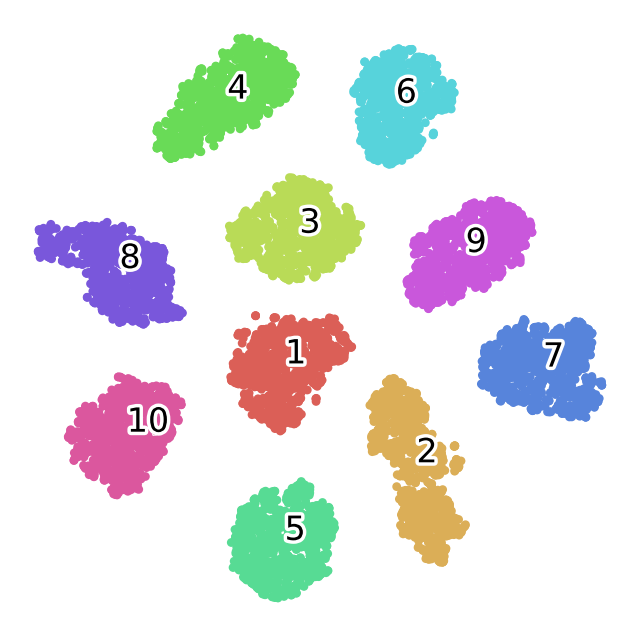

In [13]:
tsne_proj = TSNE(random_state=42).fit_transform(x_train_numpy)

scatter(tsne_proj, y_train_numpy)

## Metrics

In [14]:
def mean_distance(codings, label, c=10):
    codings_per_class = []  # [(16, ) * 10]
    for i in range(c):
        codings_per_class.append(codings[label == i, :])
    centers = [torch.mean(codings_per_class[i], 0) for i in range(c)]
    
    inter_class_distance = torch.tensor(0.)
    for k in range(c - 1):
        for t in range(k + 1, c):
            inter_class_distance += torch.dist(centers[k], centers[t], p=2)
    mean_inter_class_distance = inter_class_distance / (c * (c - 1) / 2)
    
    intra_class_distance = torch.tensor(0.)
    for i in range(c):
        per_intra_class_distance = torch.tensor(0.)
        per_class_features = codings_per_class[i]
        center_feature = centers[i]
        num = per_class_features.size(0)
        for j in range(num):
            per_intra_class_distance += torch.dist(per_class_features[j], center_feature, p=2)
        per_intra_class_distance = per_intra_class_distance / num
        
        intra_class_distance += per_intra_class_distance
    mean_intra_class_distance = intra_class_distance / c
    return mean_intra_class_distance, mean_inter_class_distance

In [15]:
mean_intra_class_distance, mean_inter_class_distance = mean_distance(x_train, y_train)

mean_intra_class_distance, mean_inter_class_distance

(tensor(5.1001), tensor(22.4725))

## Testing

In [16]:
tar_test, pre_test = test(model, valid_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [17]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 98.76, AA: 98.76, Kappa: 0.9863
*******************************************************************
Recal: [99.35 99.33 98.97 98.6  98.33 98.71 99.57 98.52 98.06 98.11]
*******************************************************************
